In [1]:
import pickle
import pandas as pd
import copy
import torch
import numpy as np
import math
import random
from tqdm.autonotebook import tqdm

In [2]:
with open("toy_dataset.pkl", "rb") as f:
    everything = pickle.load(f)

In [3]:
train_df = pd.DataFrame({'x' : everything['train'][0], 'y' : everything['train'][1]})
test_df = pd.DataFrame({'x' : everything['test'][0], 'y' : everything['test'][1]})
val_df = pd.DataFrame({'x' : everything['val'][0], 'y' : everything['val'][1]})

In [4]:
from torch.utils.data import Dataset, DataLoader

In [5]:
class S2SDataset(Dataset):
    def __init__(self, df, eos):
        self.df = df
        self.eos = eos
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        X = copy.copy(self.df.iloc[idx][0])
        Y = copy.copy(self.df.iloc[idx][1])
        
        X.append(self.eos)
        Y.append(self.eos)
        
        return (X, Y)

In [6]:
def MyDataLoader(dataset, idxs, batch_sizes, boundaries, pad_value, num_batchs = 600):
    bucket_src = [[] for _ in range(len(batch_sizes))]
    bucket_dst = [[] for _ in range(len(batch_sizes))]
    
    boundaries = boundaries + [math.inf]
    count = 0
    for idx in idxs:
        sent, trans = train_data[idx]
        length = len(sent)

        bucket_idx = min([i for i, b in enumerate(boundaries) if length <= b])
        bucket_src[bucket_idx].append(sent)
        bucket_dst[bucket_idx].append(trans)

        if len(bucket_src[bucket_idx]) == batch_sizes[bucket_idx]:
            count += 1
            batch_x = []
            batch_y = []
            for x, y in zip(bucket_src[bucket_idx], bucket_dst[bucket_idx]):
                batch_x.append(pad_sequence(x, boundaries[bucket_idx], pad_value))
                batch_y.append(pad_sequence(y, boundaries[bucket_idx], pad_value))
                
            yield torch.LongTensor(batch_x), torch.LongTensor(batch_y)
            if(count == num_batchs):
                break
            bucket_src[bucket_idx] = []
            bucket_dst[bucket_idx] = []

def pad_sequence(ex, max_len, pad_value):
    ex = np.array(ex)
    
    ex = np.pad(ex, (0, max_len - len(ex)), constant_values = pad_value)
    return ex

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

In [8]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        super(Encoder, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.cell = nn.GRU(emb_size, hidden_size, batch_first = True)
        
    def forward(self, x):
        x = self.emb(x)
        _, hidden = self.cell(x)
        
        return hidden

In [9]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        super(Decoder, self).__init__()
        
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.cell = nn.GRU(emb_size, hidden_size, batch_first = True)
        
        self.outt = nn.Linear(hidden_size, vocab_size)
        self.logsoftmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, x, hidden):
        x = self.emb(x)
        
        out, hidden = self.cell(x, hidden)
        
        out = self.outt(out.squeeze(1))
        
        return self.logsoftmax(out), hidden

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
words = stopwords.words('english')

word2idx = {}

for i in range(20):
    word2idx[i] = words[i]

idx2word = dict(zip(word2idx.values(), word2idx.keys()))

chencherry = SmoothingFunction()

In [11]:
dec = Decoder(20, 50, 32)
enc = Encoder(20, 50, 32)

batch_sizes = [64, 32, 8]
boundaries = [6, 8, 10]

loss = nn.NLLLoss()

enc_opt = optim.Adam(enc.parameters(), lr = 0.001)
dec_opt = optim.Adam(dec.parameters(), lr = 0.001)

dec = dec.cuda()
enc = enc.cuda()

device = 'cuda'

train_data = S2SDataset(train_df, everything['meta']['eos'])
test_data = S2SDataset(test_df, everything['meta']['eos'])

In [12]:
def get_loader(data, batch_sizes, boundaryies, pad_value):
    idxs = list(range(len(data)))
    random.shuffle(idxs)

    loader = MyDataLoader(data, idxs, batch_sizes, boundaries, pad_value=0)
    
    return loader

def format_for_bleu_score(sent_list, word2idx, is_ref = False):
    ref = []
    for r in sent_list.numpy():
        if is_ref:
            ref.append([list(map(lambda x: word2idx[x], r))])
        else:            
            ref.append(list(map(lambda x: word2idx[x], r)))
            
    return ref

In [13]:
def run_val_set(loader, enc, dec, loss_func):
    test_bleu = 0
    total_cost = 0
    count = 0
    with torch.no_grad():
        for j, (X, Y) in enumerate(loader):
            X = X.to(device)
            Y = Y.to(device)
            
            enc_hidden = enc(X)

            SOS = torch.LongTensor([[0] * len(Y)]).to(device)
            hidden = enc_hidden
            y_in = SOS.view(-1, 1)
            book = []

            for i in range(Y.shape[1]):
                out, hidden = dec(y_in, hidden)
                book.append(out.squeeze(1))

                _, next_in = out.topk(1)
                y_in = next_in

            pred = torch.stack(book, dim = 1)
            pred = pred.permute(0, 2, 1)
            cost = loss_func(pred, Y)
        
            _, pred_idx = pred.topk(1, dim = 1)

            candidate = pred_idx.squeeze(1)
            reference = Y

            cand = format_for_bleu_score(candidate.cpu(), word2idx, is_ref=False)
            refe = format_for_bleu_score(reference.cpu(), word2idx, is_ref=True)

            test_bleu += corpus_bleu(refe, cand, smoothing_function=chencherry.method1)
            total_cost += cost.item()
            count += 1
            
    return test_bleu / count, total_cost / count

In [14]:
import matplotlib.pyplot as plt

class Book:
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_bleu = []
        self.val_bleu = []
        
    def update_book(self, tloss, vloss, tbleu, vbleu):
        self.train_loss.append(tloss)
        self.val_loss.append(vloss)
        self.train_bleu.append(tbleu)
        self.val_bleu.append(vbleu)
        
    def plot_loss(self):
        length = list(range(len(self.train_loss)))
        
        plt.plot(length, self.train_loss, label='Train Loss')
        plt.plot(length, self.val_loss, label='Validation Loss')
        plt.title("Loss Curves")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        
        plt.show()
        
    def plot_bleu(self):
        length = list(range(len(self.train_bleu)))
        
        plt.plot(length, self.train_bleu, label='Train Bleu')
        plt.plot(length, self.val_bleu, label='Validation Bleu')
        plt.title("Bleu Curves")
        plt.xlabel("Epochs")
        plt.ylabel("Bleu Score")
        plt.legend()
        
        plt.show()

In [15]:
metrics = Book()

In [16]:
for epoch in tqdm(range(30)):
    loader = get_loader(train_data, batch_sizes, boundaries, pad_value = 0)
    
    epoch_loss = 0
    epoch_bleu_score = 0
    for j, (X, Y) in enumerate(tqdm(loader, total = 600)):
        X = X.to(device)
        Y = Y.to(device)
        
        enc_opt.zero_grad()
        dec_opt.zero_grad()

        enc_hidden = enc(X)
        SOS = torch.LongTensor([[0] * len(Y)]).to(device)
        hidden = enc_hidden
        y_in = SOS.view(-1, 1)
        book = []

        use_teacher_forcing = np.random.uniform() <= 0.5

        if use_teacher_forcing:
            for i in range(Y.shape[1]):
                out, hidden = dec(y_in, hidden)
                book.append(out.squeeze(1))

                y_in = Y[:, i].view(-1, 1)
        else:
            for i in range(Y.shape[1]):
                out, hidden = dec(y_in, hidden)
                book.append(out.squeeze(1))

                _, next_in = out.topk(1)
                y_in = next_in

        pred = torch.stack(book, dim = 1)

        pred = pred.permute(0, 2, 1)
        cost = loss(pred, Y)
        cost.backward()

        enc_opt.step()
        dec_opt.step()

        _, pred_idx = pred.topk(1, dim = 1)

        candidate = pred_idx.squeeze(1)
        reference = Y

        cand = format_for_bleu_score(candidate.cpu(), word2idx, is_ref=False)
        refe = format_for_bleu_score(reference.cpu(), word2idx, is_ref=True)
        
        bleu_score = corpus_bleu(refe, cand, smoothing_function=chencherry.method1)

        epoch_loss += cost.item()
        epoch_bleu_score += bleu_score
        
        print(f"Epoch : {epoch + 1} Loss : {epoch_loss / (j + 1):.3f} Bleu : {epoch_bleu_score * 100 / (j + 1):.1f}", end='\r')
    
    
    test_loader = get_loader(test_data, batch_sizes, boundaries, pad_value = 0)
    val_bleu, val_loss = run_val_set(test_loader, enc, dec, loss)
    
    metrics.update_book(epoch_loss / (j + 1), val_loss, epoch_bleu_score * 100 / (j + 1), val_bleu * 100)
    
    print(f"\nBleu Score on Validation set : {val_bleu * 100:.1f}")

Epoch : 1 Loss : 2.438 Bleu : 2.3

Bleu Score on Validation set : 4.1


Epoch : 2 Loss : 2.026 Bleu : 5.07

Bleu Score on Validation set : 5.7


Epoch : 3 Loss : 1.828 Bleu : 7.4

Bleu Score on Validation set : 8.9


Epoch : 4 Loss : 1.703 Bleu : 9.32

Bleu Score on Validation set : 11.0


Epoch : 5 Loss : 1.573 Bleu : 12.3

Bleu Score on Validation set : 13.4


Epoch : 6 Loss : 1.467 Bleu : 15.2

Bleu Score on Validation set : 15.6


Epoch : 7 Loss : 1.395 Bleu : 17.9

Bleu Score on Validation set : 18.4


Epoch : 8 Loss : 1.306 Bleu : 20.8

Bleu Score on Validation set : 18.9


Epoch : 9 Loss : 1.220 Bleu : 23.7

Bleu Score on Validation set : 23.1


Epoch : 10 Loss : 1.150 Bleu : 26.3

Bleu Score on Validation set : 24.7


Epoch : 11 Loss : 1.072 Bleu : 29.8

Bleu Score on Validation set : 29.0


Epoch : 12 Loss : 1.046 Bleu : 31.7

Bleu Score on Validation set : 27.9


Epoch : 13 Loss : 0.994 Bleu : 33.6

Bleu Score on Validation set : 31.1


Epoch : 14 Loss : 0.973 Bleu : 35.3

Bleu Score on Validation set : 33.5


Epoch : 15 Loss : 0.926 Bleu : 37.5

Bleu Score on Validation set : 35.9


Epoch : 16 Loss : 0.884 Bleu : 40.4

Bleu Score on Validation set : 43.0


Epoch : 17 Loss : 0.860 Bleu : 42.7

Bleu Score on Validation set : 41.2


Epoch : 18 Loss : 0.848 Bleu : 43.1

Bleu Score on Validation set : 42.3


Epoch : 19 Loss : 0.826 Bleu : 44.4

Bleu Score on Validation set : 41.8


Epoch : 20 Loss : 0.768 Bleu : 48.5

Bleu Score on Validation set : 46.2


Epoch : 21 Loss : 0.767 Bleu : 48.6

Bleu Score on Validation set : 47.6


Epoch : 22 Loss : 0.736 Bleu : 50.0

Bleu Score on Validation set : 51.7


Epoch : 23 Loss : 0.730 Bleu : 51.0

Bleu Score on Validation set : 52.0


Epoch : 24 Loss : 0.705 Bleu : 52.4

Bleu Score on Validation set : 54.3


Epoch : 25 Loss : 0.688 Bleu : 54.2

Bleu Score on Validation set : 52.5


Epoch : 26 Loss : 0.650 Bleu : 56.1

Bleu Score on Validation set : 53.5


Epoch : 27 Loss : 0.642 Bleu : 57.3

Bleu Score on Validation set : 52.9


Epoch : 28 Loss : 0.608 Bleu : 59.2

Bleu Score on Validation set : 59.9


Epoch : 29 Loss : 0.598 Bleu : 60.1

Bleu Score on Validation set : 54.4


Epoch : 30 Loss : 0.587 Bleu : 60.4

Bleu Score on Validation set : 58.1



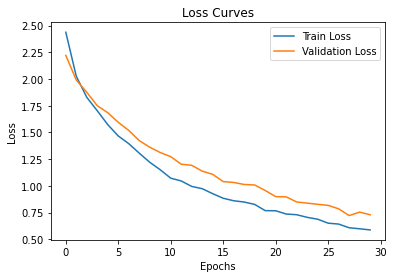

In [17]:
metrics.plot_loss()

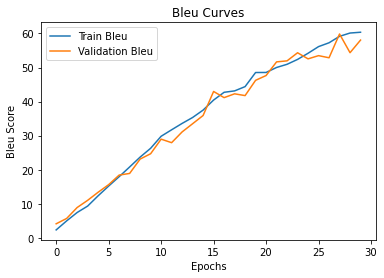

In [18]:
metrics.plot_bleu()